<a href="https://colab.research.google.com/github/DevNicque/MyCods/blob/master/Alzheimers_Dementia_Stage_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Configurações

In [1]:
! pip3 install opencv-python
! pip3 install keras
! pip3 install tensorflow
! pip3 install sklearn

     |████████████████████████████████| 462 kB 8.5 MB/s 


In [2]:
! pip3 install shap

     |████████████████████████████████| 564 kB 8.0 MB/s 


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import copy
import warnings
warnings.filterwarnings('ignore')

import cv2
import keras
import tensorflow as tf
# example of loading the vgg16 model
# from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
# # from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
# from tensorflow.keras.applications.resnet_v2 import ResNet50V2,preprocess_input
# from keras.applications.resnet import ResNet50,preprocess_input
# from tensorflow.keras.applications.efficientnet import EfficientNetB7, preprocess_input
from keras.layers import Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array
import matplotlib
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
import shap
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path = 'drive/MyDrive/TCC/Alzheimer_Dataset/'

## Funções e Configurações

In [6]:
CATEGORIES = ['MildDemented','ModerateDemented','NonDemented','VeryMildDemented']

In [7]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc')
]

In [8]:
#checkpoint_filepath = '{epoch:02d}-{val_loss:.7f}.hdf5'
checkpoint_filepath = '{epoch:02d}.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True)

earlystop = EarlyStopping(monitor = 'val_accuracy', 
                          min_delta = 0, 
                          patience = 50,
                          verbose = 1,
                          mode='auto')

reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',
                              factor = 0.2,
                              patience = 30,
                              verbose = 1,
                              min_delta = 0.0001)

# we put our call backs into a callback list
callbacks = [earlystop, model_checkpoint_callback, reduce_lr]

In [26]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision, recall, val_recall):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(recall) + 1), recall)
    ax5.plot(range(1, len(val_recall) + 1), val_recall)
    ax5.set_title('History of Recall')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('Recall')
    ax5.legend(['training', 'validation'])
    

    plt.show()

In [55]:
def matrix_confunsion_metric(model, x_test, y_test, y_preds, y_trues):
    ## plot confusion matrix
    y_preds = model.predict(x_test)
    y_preds = np.argmax(y_preds, axis=1)
    y_trues = np.argmax(y_test, axis=1)
    cm = confusion_matrix(y_trues, y_preds)

    fig, ax = plt.subplots(figsize=(12, 9))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'shrink': .3}, linewidths=.1, ax=ax)

    ax.set(
        xticklabels=list(label_to_class.keys()),
        yticklabels=list(label_to_class.keys()),
        title='confusion matrix',
        ylabel='True label',
        xlabel='Predicted label'
    )
    params = dict(rotation=45, ha='center', rotation_mode='anchor')
    plt.setp(ax.get_yticklabels(), **params)
    plt.setp(ax.get_xticklabels(), **params)
    
    plt.show()
    
    

In [11]:
def plot_train_result(predictions):
    rows = 2
    columns = 5
    fig, axs= plt.subplots(rows, columns , figsize=(25, 10))
    axs = axs.flatten()
    i=10
    
    for a in axs:
        Image = Images[i]
        pred_label=predictions.argmax(axis=1)[i]
        actual_label=y_test.argmax(axis=1)[i]
        pred_label=CATEGORIES[pred_label]
        actual_label=CATEGORIES[actual_label]
        label= 'pred: '+ pred_label +' '+'real: '+ actual_label
        #axs[i](rows,columns,i)
        a.imshow(np.uint8(Image))
        a.set_title(label)
        i=i+1

    plt.show()

In [12]:
W = 224
H = 224
#168

label_to_class = {
    'MildDemented': 0,
    'ModerateDemented': 1,
    'NonDemented': 2,
    'VeryMildDemented':3
    

}
class_to_label = {v: k for k, v in label_to_class.items()}
n_classes = len(label_to_class)

def get_images(dir_name= path, label_to_class=label_to_class):
    """read images / labels from directory"""
    
    Images = []
    Classes = []
    
    for j in ['/train','/test']:
        for label_name in os.listdir(dir_name+str(j)):
            cls = label_to_class[label_name]

            for img_name in os.listdir('/'.join([dir_name+str(j), label_name])):
                img = load_img('/'.join([dir_name+str(j), label_name, img_name]), target_size=(W, H))
                img = img_to_array(img)

                Images.append(img)
                Classes.append(cls)
            
    Images = np.array(Images, dtype=np.float32)
    Classes = np.array(Classes, dtype=np.float32)
    Images, Classes = shuffle(Images, Classes, random_state=0)
    
    return Images, Classes

## Importação de Dados

In [13]:
## get images / labels
Images, Classes = get_images()

Images.shape, Classes.shape

((6410, 224, 224, 3), (6410,))

## Pré-processamento

In [14]:
## split train / test

indices_train, indices_test = train_test_split(list(range(Images.shape[0])), train_size=0.8, test_size=0.2, shuffle=False)

x_train = Images[indices_train]
y_train = Classes[indices_train]
x_test = Images[indices_test]
y_test = Classes[indices_test]

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5128, 224, 224, 3), (5128,), (1282, 224, 224, 3), (1282,))

In [15]:
from keras.utils import np_utils
## to one-hot

y_train = keras.utils.np_utils.to_categorical(y_train, n_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, n_classes)

y_train.shape, y_test.shape

((5128, 4), (1282, 4))

## RESNET

In [ ]:
## to image data generator
from tensorflow.keras.applications.resnet_v2 import ResNet50V2,preprocess_input
datagen_train = ImageDataGenerator(
    preprocessing_function=preprocess_input, # image preprocessing function
    rotation_range=30,                       # randomly rotate images in the range
    width_shift_range=0.1,                   # randomly shift images horizontally
    height_shift_range=0.1,                  # randomly shift images vertically
    horizontal_flip=True,                    # randomly flip images horizontally
    vertical_flip=False,                     # randomly flip images vertically
)
datagen_test = ImageDataGenerator(
    preprocessing_function=preprocess_input, # image preprocessing function
)

In [ ]:
# load model
model = keras.models.Sequential()

# load model
ResNet = ResNet50V2(weights='imagenet',include_top=False, input_shape=(W,H,3),pooling='avg')    
print(ResNet.summary())
# Freezing Layers

for layer in ResNet.layers:
    layer.trainable=False
    
model.add(ResNet)
model.add(Flatten())
model.add(Dense(512,activation='relu',kernel_initializer='he_uniform'))
model.add(Dense(128,activation='relu',kernel_initializer='he_uniform'))
model.add(Dense(32,activation='relu',kernel_initializer='he_uniform'))
model.add(Dense(n_classes,activation='softmax'))


94683136/94668760 [==============================] - 1s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                        

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 4)                 132       
                                                                 
Total params: 24,683,812
Trainable params: 1,119,012
Non

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=METRICS)

epochs = 100
history=model.fit(datagen_train.flow(x_train,y_train, batch_size=128,shuffle=True), epochs=epochs,validation_data=datagen_test.flow(x_test,y_test, batch_size=32,shuffle=True), callbacks=callbacks )

Epoch 1/100
41/41 [==============================] - ETA: 0s - loss: 21.7359 - accuracy: 0.7036 - precision: 0.4070 - recall: 0.4058 - auc: 0.6590 
Epoch 1: val_accuracy improved from -inf to 0.77145, saving model to 01.h5
41/41 [==============================] - 906s 22s/step - loss: 21.7359 - accuracy: 0.7036 - precision: 0.4070 - recall: 0.4058 - auc: 0.6590 - val_loss: 2.1948 - val_accuracy: 0.7715 - val_precision: 0.5429 - val_recall: 0.5429 - val_auc: 0.7976 - lr: 0.0010
Epoch 2/100
41/41 [==============================] - ETA: 0s - loss: 3.2685 - accuracy: 0.7235 - precision: 0.4457 - recall: 0.4343 - auc: 0.7076 
Epoch 2: val_accuracy did not improve from 0.77145
41/41 [==============================] - 944s 23s/step - loss: 3.2685 - accuracy: 0.7235 - precision: 0.4457 - recall: 0.4343 - auc: 0.7076 - val_loss: 1.7590 - val_accuracy: 0.7163 - val_precision: 0.4316 - val_recall: 0.4259 - val_auc: 0.7371 - lr: 0.0010
Epoch 3/100
41/41 [==============================] - ETA: 0s -

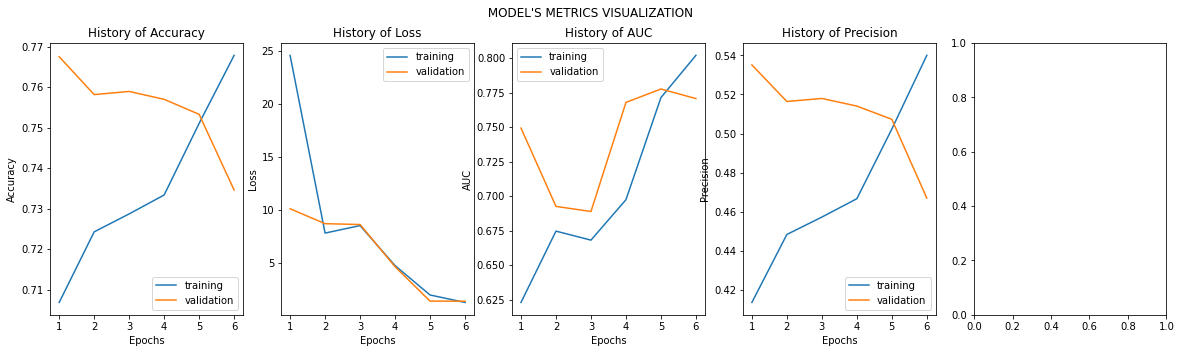

In [ ]:
Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision']              )

In [ ]:
predictions=model.predict(x_test)

np.array(predictions)

array([[4.2471331e-02, 8.6274836e-04, 5.1346248e-01, 4.4320342e-01],
       [1.4563403e-02, 3.2626882e-03, 1.9201311e-01, 7.9016083e-01],
       [1.6901405e-03, 6.7753033e-05, 9.3229318e-01, 6.5949000e-02],
       ...,
       [9.8700849e-03, 2.1670784e-03, 6.5404791e-01, 3.3391485e-01],
       [1.3677247e-03, 4.2602689e-05, 5.1275182e-01, 4.8583791e-01],
       [1.3999695e-02, 3.2247079e-03, 8.7335944e-02, 8.9543968e-01]],
      dtype=float32)

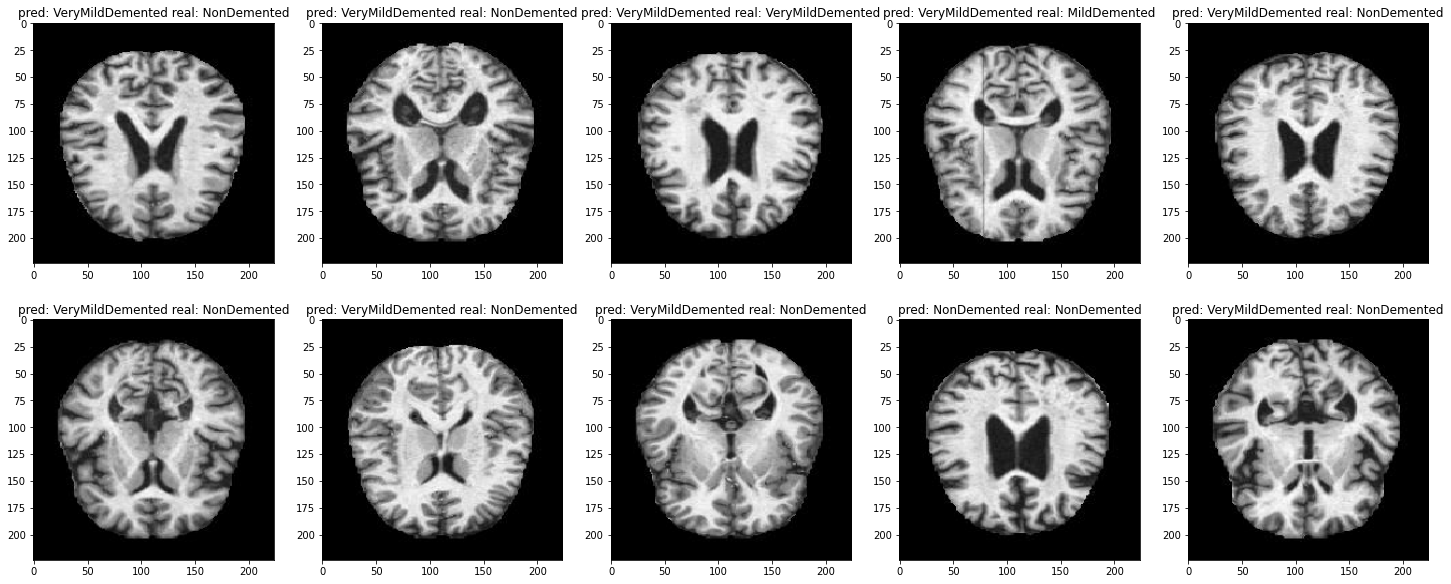

In [ ]:
plot_train_result(predictions)

In [ ]:
## plot confusion matrix
y_preds = model.predict(x_test)
y_preds = np.argmax(y_preds, axis=1)
y_trues = np.argmax(y_test, axis=1)

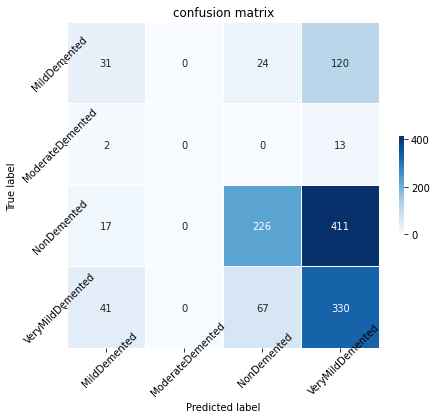

In [ ]:
matrix_confunsion_metric(model, x_test, y_test, y_preds,y_trues)


In [ ]:
print("F1 Score (testing): %.2f%%"% (f1_score(y_trues, y_preds, average='weighted')*100.0))


F1 Score (testing): 44.12%


In [ ]:
print("accuracy (testing): %.2f%%"% (accuracy_score(y_trues, y_preds)*100.0))

accuracy (testing): 45.79%


In [ ]:
report = classification_report(y_trues, y_preds)
print(report)

              precision    recall  f1-score   support

           0       0.34      0.18      0.23       175
           1       0.00      0.00      0.00        15
           2       0.71      0.35      0.47       654
           3       0.38      0.75      0.50       438

    accuracy                           0.46      1282
   macro avg       0.36      0.32      0.30      1282
weighted avg       0.54      0.46      0.44      1282



## InceptionNet

In [ ]:
## to image data generator
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
datagen_train = ImageDataGenerator(
    preprocessing_function=preprocess_input, # image preprocessing function
    rotation_range=30,                       # randomly rotate images in the range
    width_shift_range=0.1,                   # randomly shift images horizontally
    height_shift_range=0.1,                  # randomly shift images vertically
    horizontal_flip=True,                    # randomly flip images horizontally
    vertical_flip=False,                     # randomly flip images vertically
)
datagen_test = ImageDataGenerator(
    preprocessing_function=preprocess_input, # image preprocessing function
)

In [ ]:
model2 = keras.models.Sequential()

# load model
Inception = InceptionResNetV2(weights='imagenet',include_top=False, input_shape=(W,H,3),pooling='avg')    
print(Inception.summary())
# Freezing Layers

for layer in Inception.layers:
    layer.trainable=False
    
model2.add(Inception)
model2.add(Flatten())
model2.add(Dense(512,activation='relu',kernel_initializer='he_uniform'))
model2.add(Dense(128,activation='relu',kernel_initializer='he_uniform'))
model2.add(Dense(32,activation='relu',kernel_initializer='he_uniform'))
model2.add(Dense(n_classes,activation='softmax'))


219070464/219055592 [==============================] - 2s 0us/step
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)  

In [ ]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=METRICS)

epochs = 100
history2 = model2.fit(datagen_train.flow(x_train,y_train, batch_size=128,shuffle=True), epochs=epochs,validation_data=datagen_test.flow(x_test,y_test, batch_size=32,shuffle=True), callbacks=callbacks )

Epoch 1/100
41/41 [==============================] - ETA: 0s - loss: 177.0918 - accuracy: 0.6956 - precision: 0.3897 - recall: 0.3844 - auc: 0.6079
Epoch 1: val_accuracy did not improve from 0.76755
41/41 [==============================] - 141s 3s/step - loss: 177.0918 - accuracy: 0.6956 - precision: 0.3897 - recall: 0.3844 - auc: 0.6079 - val_loss: 162.5170 - val_accuracy: 0.6708 - val_precision: 0.3417 - val_recall: 0.3417 - val_auc: 0.5611 - lr: 0.0010
Epoch 2/100
41/41 [==============================] - ETA: 0s - loss: 54.7472 - accuracy: 0.7030 - precision: 0.4060 - recall: 0.4060 - auc: 0.6109
Epoch 2: val_accuracy did not improve from 0.76755
41/41 [==============================] - 125s 3s/step - loss: 54.7472 - accuracy: 0.7030 - precision: 0.4060 - recall: 0.4060 - auc: 0.6109 - val_loss: 40.0344 - val_accuracy: 0.5683 - val_precision: 0.1365 - val_recall: 0.1365 - val_auc: 0.4243 - lr: 0.0010
Epoch 3/100
41/41 [==============================] - ETA: 0s - loss: 25.6186 - accu

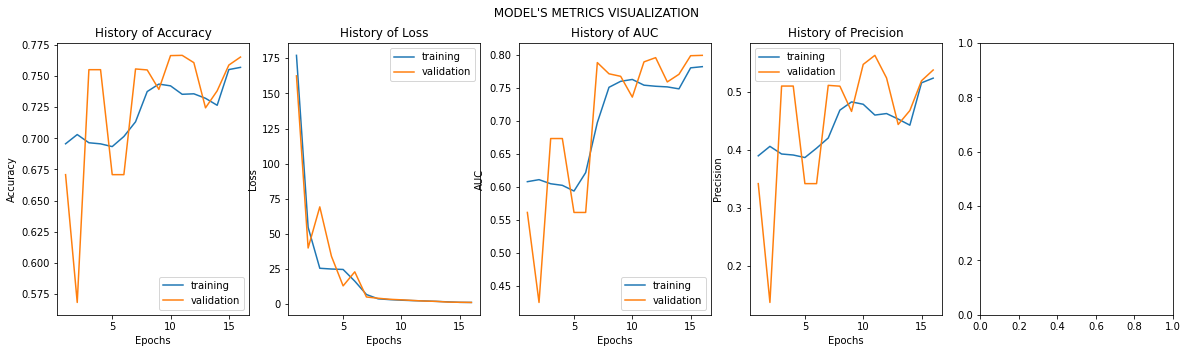

In [ ]:
Train_Val_Plot(history2.history['accuracy'],history2.history['val_accuracy'],
               history2.history['loss'],history2.history['val_loss'],
               history2.history['auc'],history2.history['val_auc'],
               history2.history['precision'],history2.history['val_precision']              )

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 1536)             54336736  
 onal)                                                           
                                                                 
 flatten_1 (Flatten)         (None, 1536)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               786944    
                                                                 
 dense_5 (Dense)             (None, 128)               65664     
                                                                 
 dense_6 (Dense)             (None, 32)                4128      
                                                                 
 dense_7 (Dense)             (None, 4)                 132       
                                                      

In [ ]:
predictions2 = model2.predict(x_test)

np.array(predictions2)

array([[1.43262058e-01, 4.96841490e-15, 4.77754742e-01, 3.78983229e-01],
       [1.46936446e-01, 6.20930551e-09, 5.80227852e-01, 2.72835732e-01],
       [1.52904108e-01, 8.48657895e-14, 4.90131885e-01, 3.56964022e-01],
       ...,
       [1.23584330e-01, 2.01253684e-12, 5.46629190e-01, 3.29786450e-01],
       [1.11391045e-01, 6.64804854e-14, 4.21049833e-01, 4.67559069e-01],
       [1.25774547e-01, 7.45418592e-13, 5.21635354e-01, 3.52590084e-01]],
      dtype=float32)

In [ ]:
y_preds2 = model2.predict(x_test)
y_preds2 = np.argmax(y_preds2, axis=1)
y_trues2 = np.argmax(y_test, axis=1)

In [ ]:
matrix_confunsion_metric(model2, x_test, y_test, y_preds2, y_trues2)

In [ ]:
plot_train_result(predictions2)

In [ ]:
print("F1 Score (testing): %.2f%%"% (f1_score(y_trues2, y_preds2, average='weighted')*100.0))
print("accuracy (testing): %.2f%%"% (accuracy_score(y_trues2, y_preds2)*100.0))
report2 = classification_report(y_trues2, y_preds2)
print(report2)

## EfficientNetB7

In [16]:
## to image data generator
from tensorflow.keras.applications.efficientnet import EfficientNetB7, preprocess_input
datagen_train = ImageDataGenerator(
    preprocessing_function=preprocess_input, # image preprocessing function
    rotation_range=30,                       # randomly rotate images in the range
    width_shift_range=0.1,                   # randomly shift images horizontally
    height_shift_range=0.1,                  # randomly shift images vertically
    horizontal_flip=True,                    # randomly flip images horizontally
    vertical_flip=False,                     # randomly flip images vertically
)
datagen_test = ImageDataGenerator(
    preprocessing_function=preprocess_input, # image preprocessing function
)

In [17]:
model3 = keras.models.Sequential()

# load model
Efficient = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(W,H,3),pooling='avg')    
print(Efficient.summary())
# Freezing Layers

for layer in Efficient.layers:
    layer.trainable=False
    
model3.add(Efficient)
model3.add(Flatten())
model3.add(Dense(512,activation='relu',kernel_initializer='random_uniform'))
model3.add(Dense(128,activation='relu',kernel_initializer='random_uniform'))
model3.add(Dense(32,activation='relu',kernel_initializer='random_uniform'))
model3.add(Dense(n_classes,activation='softmax'))


258088960/258076736 [==============================] - 2s 0us/step
Model: "efficientnetb7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (Ze

In [18]:
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional)  (None, 2560)             64097687  
                                                                 
 flatten (Flatten)           (None, 2560)              0         
                                                                 
 dense (Dense)               (None, 512)               1311232   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 4)                 132       
                                                                 
Total params: 65,478,843
Trainable params: 1,381,156
Non

In [19]:
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=METRICS)

epochs = 300
history3 = model3.fit(datagen_train.flow(x_train,y_train, batch_size=128,shuffle=True), epochs=epochs,validation_data=datagen_test.flow(x_test,y_test, batch_size=32,shuffle=True), callbacks=callbacks )

Epoch 1/300
41/41 [==============================] - ETA: 0s - loss: 1.0093 - accuracy: 0.7712 - precision: 0.5789 - recall: 0.3112 - auc: 0.8037
Epoch 1: val_accuracy improved from -inf to 0.78744, saving model to 01.h5
41/41 [==============================] - 105s 2s/step - loss: 1.0093 - accuracy: 0.7712 - precision: 0.5789 - recall: 0.3112 - auc: 0.8037 - val_loss: 0.9519 - val_accuracy: 0.7874 - val_precision: 0.6127 - val_recall: 0.4072 - val_auc: 0.8300 - lr: 0.0010
Epoch 2/300
41/41 [==============================] - ETA: 0s - loss: 0.9526 - accuracy: 0.7855 - precision: 0.6410 - recall: 0.3231 - auc: 0.8246
Epoch 2: val_accuracy did not improve from 0.78744
41/41 [==============================] - 64s 2s/step - loss: 0.9526 - accuracy: 0.7855 - precision: 0.6410 - recall: 0.3231 - auc: 0.8246 - val_loss: 0.9517 - val_accuracy: 0.7779 - val_precision: 0.5716 - val_recall: 0.4454 - val_auc: 0.8260 - lr: 0.0010
Epoch 3/300
41/41 [==============================] - ETA: 0s - loss: 

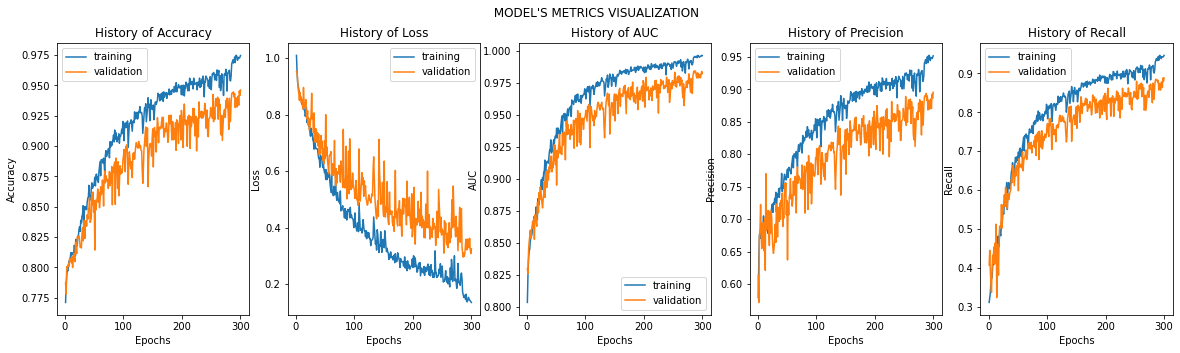

In [29]:
Train_Val_Plot(history3.history['accuracy'],history3.history['val_accuracy'],
               history3.history['loss'],history3.history['val_loss'],
               history3.history['auc'],history3.history['val_auc'],
               history3.history['precision'],history3.history['val_precision'],
               history3.history['recall'],history3.history['val_recall'])       

In [30]:
predictions3 = model3.predict(x_test)

np.array(predictions3)


array([[1.2823790e-05, 4.0768744e-10, 3.4611627e-01, 6.5387088e-01],
       [6.3206055e-03, 2.5035886e-06, 9.0668195e-01, 8.6994991e-02],
       [3.7689595e-08, 1.9629902e-11, 9.9989486e-01, 1.0513792e-04],
       ...,
       [8.2472485e-04, 2.9444436e-06, 9.0763131e-03, 9.9009609e-01],
       [6.6603575e-06, 1.1383253e-10, 9.9997222e-01, 2.1126440e-05],
       [2.2630958e-05, 1.0750507e-09, 9.9997711e-01, 2.0370298e-07]],
      dtype=float32)

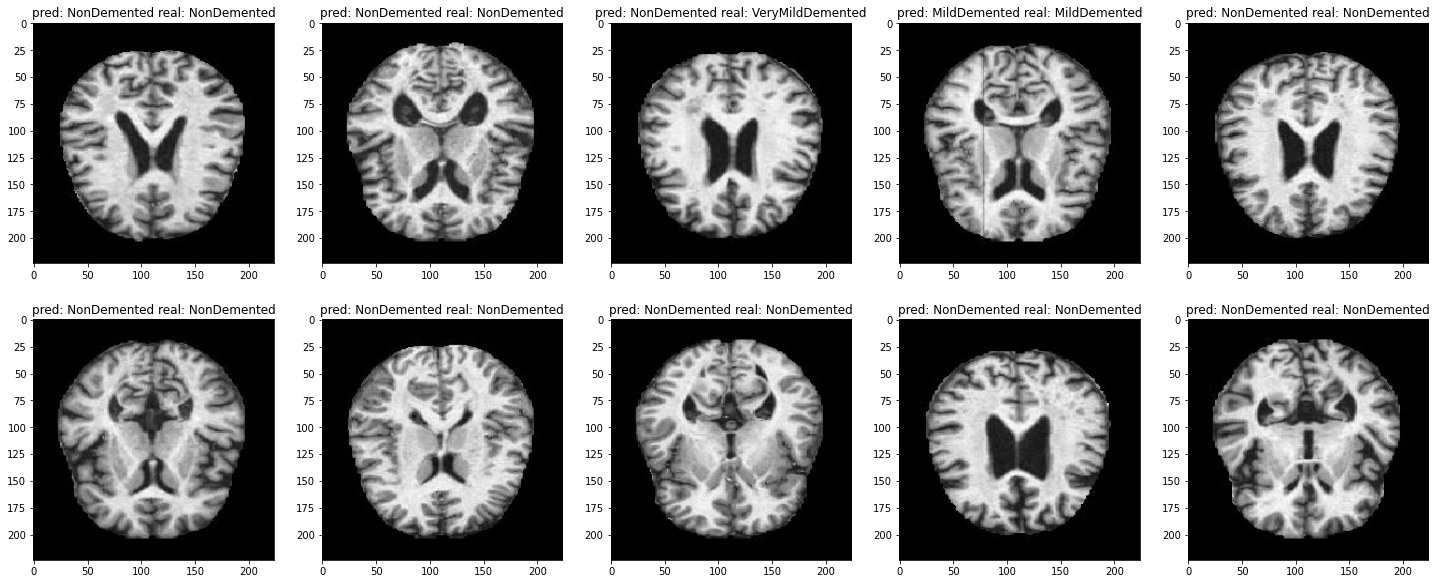

In [22]:
plot_train_result(predictions3)

In [23]:
y_preds3 = model3.predict(x_test)
y_preds3 = np.argmax(y_preds3, axis=1)
y_trues3 = np.argmax(y_test, axis=1)

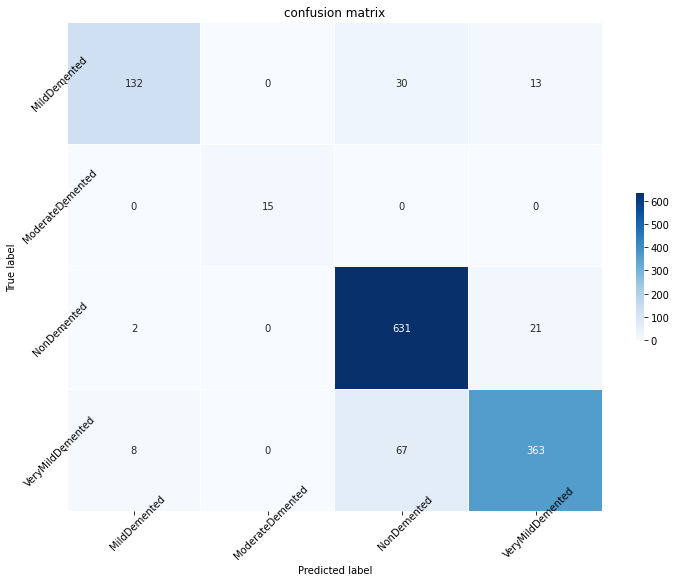

In [56]:
matrix_confunsion_metric(model3, x_test, y_test, y_preds3,y_trues3)

In [49]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, recall_score, roc_auc_score, precision_score

In [50]:
print("F1 Score (testing): %.2f%%"% (f1_score(y_trues3, y_preds3, average='weighted')*100.0))
print("accuracy (testing): %.2f%%"% (accuracy_score(y_trues3, y_preds3)*100.0))
print("recall (testing): %.2f%%"% (recall_score(y_trues3, y_preds3, average='weighted')*100.0))
print("precisão (testing): %.2f%%"% (precision_score(y_trues3, y_preds3, average='weighted')*100.0))
report3 = classification_report(y_trues3, y_preds3)
print(report3)

F1 Score (testing): 88.83%
accuracy (testing): 89.00%
recall (testing): 89.00%
precisão (testing): 89.32%
              precision    recall  f1-score   support

           0       0.93      0.75      0.83       175
           1       1.00      1.00      1.00        15
           2       0.87      0.96      0.91       654
           3       0.91      0.83      0.87       438

    accuracy                           0.89      1282
   macro avg       0.93      0.89      0.90      1282
weighted avg       0.89      0.89      0.89      1282



In [47]:
import pickle
 
# Save the trained model as a pickle string.
saved_model = pickle.dumps(model3)
 
# Load the pickled model
knn_from_pickle = pickle.loads(saved_model)
 
# Use the loaded pickled model to make predictions
# knn_from_pickle.predict(X_test)

INFO:tensorflow:Assets written to: ram://23ff3122-351f-4cfb-9f39-2f1a1fd01f9b/assets


In [52]:
import joblib

In [54]:
#from sklearn.externals import joblib
 
# Save the model as a pickle in a file
joblib.dump(model3, path + 'efficiente.pkl')
 
# # Load the model from the file
# knn_from_joblib = joblib.load('filename.pkl')
 
# # Use the loaded model to make predictions
# knn_from_joblib.predict(X_test)

INFO:tensorflow:Assets written to: ram://f9a58b3e-a5df-45bf-bf76-c5c0c8f9aeab/assets


['drive/MyDrive/TCC/Alzheimer_Dataset/efficiente.pkl']